## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
# %matplotlib qt


Bad key text.latex.unicode in file c:\users\luca\anaconda3\envs\conda-cv-nd\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file c:\users\luca\anaconda3\envs\conda-cv-nd\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key nbagg.transparent in file c:\users\luca\anaconda3\envs\conda-cv-nd\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 426 ('nbagg.transparent: True')
You probably need to get an updated ma

In [2]:
'''
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

#cv2.destroyAllWindows()
'''

"\n# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)\nobjp = np.zeros((6*9,3), np.float32)\nobjp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)\n\n# Arrays to store object points and image points from all the images.\nobjpoints = [] # 3d points in real world space\nimgpoints = [] # 2d points in image plane.\n\n# Make a list of calibration images\nimages = glob.glob('camera_cal/calibration*.jpg')\n\n# Step through the list and search for chessboard corners\nfor fname in images:\n    img = cv2.imread(fname)\n    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)\n\n    # Find the chessboard corners\n    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)\n\n    # If found, add object points, image points\n    if ret == True:\n        objpoints.append(objp)\n        imgpoints.append(corners)\n\n        # Draw and display the corners\n        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)\n        cv2.imshow('img',img)\n        cv2.waitKey(500)\n\n#cv2.destroyAllWi

## And so on and so forth...

In [3]:
def calibrate_camera(images, nx, ny, debug = 0):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return mtx, dist

In [4]:
def undistort(img, mtx, dist, debug = 0):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    if debug == 1:
        plt.figure(figsize=(24, 9))
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(dst)
        ax2.set_title('Undistorted Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return dst

def undistort_and_unwarp(img, nx, ny, mtx, dist, offset, src, debug = 0):
    img_size = (img.shape[1], img.shape[0])
    
    # Undistort using mtx and dist
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Convert to grayscale
    if len(undistorted.shape) == 3:
        undistorted_gray = cv2.cvtColor(undistorted,cv2.COLOR_RGB2GRAY)
        
    # define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([
        [offset, 0],                       # top-left corner
        [img_size[0]-offset, 0],           # top-right corner
        [offset, img_size[1]],             # bottom-left corner
        [img_size[0]-offset, img_size[1]]  # bottom-right corner
    ])

    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR)

    if debug == 1:
        plt.figure(figsize=(24, 9))
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img, cmap='gray')
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(warped, cmap='gray')
        ax2.set_title('Undistorted And Wreapped Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    return warped, M

In [5]:
nx = 9
ny = 6

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

mtx, dist = calibrate_camera(images, nx, ny, 0)

# Step through the list and search for chessboard corners
for fname in images[5:6]:
    img = cv2.imread(fname)  
    
    # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
    #src = np.float32([corners[0], corners[8], corners[45], corners[53]])
    # to be updeted with the road region of interest
    src = np.float32([[969.1136, 140.23738], [1247.3464, 172.00374], [956.5, 413], [1235.2638, 404.97147]])
    
    warped, M = undistort_and_unwarp(img, nx, ny, mtx, dist, 300, src, 0)

In [6]:
nx = 9
ny = 6
offset = 300

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

mtx, dist = calibrate_camera(images, nx, ny, 0)

images = glob.glob('test_images/test*.jpg')
images = images + glob.glob('test_images/straight_lines*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)  
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    # define 4 source points src = np.float32([[,],[,],[,],[,]])
    #src = np.float32([corners[0], corners[8], corners[45], corners[53]])
    # to be updeted with the road region of interest
    src = np.float32([[590, 440], [690, 440], [180, 680], [1100, 680]])
    
    warped, M = undistort_and_unwarp(img, nx, ny, mtx, dist, offset, src, 0)

In [91]:
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, s_thresh=(125, 255), l_thresh=(10, 100), r_thresh=(200, 255), h_thresh=(18,25), debug = 0):
    # Apply the following steps to img
    
    ### R Threshold ###
    r_channel = np.copy(img)
    # Pull r_channel
    r_channel = r_channel[:,:,0]
    # Threshold R color channel
    r_binary_output = np.zeros_like(r_channel)
    r_binary_output[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    ### R Threshold ###
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    dilated_gray = cv2.dilate(gray, (kernel_size, kernel_size))
    gray = cv2.GaussianBlur(dilated_gray, (kernel_size, kernel_size), 0)
    
    ### Gray Sobel x ###
    gray_sobel_x_thresh = [20, 100]
    # Take the derivative in x or y given orient = 'x' or 'y'
    # Take the absolute value of the derivative or gradient
    gray_abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    gray_scaled_sobel_x = np.uint8(255*gray_abs_sobel_x/np.max(gray_abs_sobel_x))
    # Threshold x gradient
    gray_sobel_x_binary_output = np.zeros_like(gray_scaled_sobel_x)
    gray_sobel_x_binary_output[(gray_scaled_sobel_x >= gray_sobel_x_thresh[0]) & (gray_scaled_sobel_x <= gray_sobel_x_thresh[1])] = 1
    ### Gray Sobel x ###
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    ### H Threshold ###
    # Detect pixels that are yellow using the hue component
    hue_binary_output =  np.zeros_like(h_channel)
    hue_binary_output[(h_channel > h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    ### H Threshold ###
    
    ### L Sobel x ###
    l_sobel_x = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    l_abs_sobelx = np.absolute(l_sobel_x) # Absolute x derivative to accentuate lines away from horizontal
    l_scaled_sobel_x = np.uint8(255*l_abs_sobelx/np.max(l_abs_sobelx))
    # Threshold x gradient
    l_binary_output = np.zeros_like(l_scaled_sobel_x)
    l_binary_output[(l_scaled_sobel_x >= l_thresh[0]) & (l_scaled_sobel_x <= l_thresh[1])] = 1
    ### L Sobel x ###
    
    ### S Threshold ###
    # Threshold color channel
    s_binary_output = np.zeros_like(s_channel)
    s_binary_output[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    ### H Threshold ###
    
    ### Yellow Threshold ###
    yellow_lower = np.array([10, np.round(0.3 * 255), np.round(0.38 * 255)])
    yellow_upper = np.array([30, np.round(0.9 * 255), np.round(1.00 * 255)])
    # Use inRange to generate a mask that identifies all yellow pixels
    yellow_mask = cv2.inRange(hls, yellow_lower, yellow_upper)
    yellow_binary_output = np.zeros_like(yellow_mask)
    yellow_binary_output[(yellow_mask > 0)] = 1
    ### Yellow Threshold ###
    
    # Stack each channel
    #color_binary = np.dstack((np.zeros_like(l_binary_output), l_binary_output, s_binary_output)) * 255
    
    # Combine all pixels detected above
    #color_binary = cv2.bitwise_or(l_binary_output, s_binary_output)
    #color_binary = cv2.bitwise_or(l_binary_output, s_binary_output)
    #color_binary = cv2.bitwise_or(color_binary, r_binary_output)
    
    # If two of the three are activated, activate in the binary image
    color_binary = np.zeros_like(s_binary_output)
    '''color_binary[((s_binary_output == 1) & (l_binary_output == 1)) 
                     | ((l_binary_output == 1) & (r_binary_output == 1))
                     | ((s_binary_output == 1) & (r_binary_output == 1))] = 1'''
    color_binary[(l_binary_output == 1)
                 | (r_binary_output == 1)
                 | ((s_binary_output == 1) | (hue_binary_output == 1))] = 1
    
    if debug == 1:
        plt.figure(figsize=(24, 9))
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(color_binary, cmap='gray')
        ax2.set_title('HLS Binary Output', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
        plt.figure(figsize=(24, 9))
        f1, (ax11, ax21, ax31, ax41, ax51) = plt.subplots(1, 5, figsize=(24, 9))
        f1.tight_layout()
        ax11.imshow(s_binary_output, cmap='gray')
        ax11.set_title('S Channel', fontsize=50)
        ax21.imshow(l_binary_output, cmap='gray')
        ax21.set_title('L Channel', fontsize=50)
        ax31.imshow(r_binary_output, cmap='gray')
        ax31.set_title('R Channel', fontsize=50)
        ax41.imshow(yellow_binary_output, cmap='gray')
        ax41.set_title('Yellow Channel', fontsize=50)
        ax51.imshow(hue_binary_output, cmap='gray')
        ax51.set_title('H Channel', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    # Return a binary image of threshold result
    return color_binary, s_binary_output, l_binary_output, r_binary_output

<Figure size 1728x648 with 0 Axes>

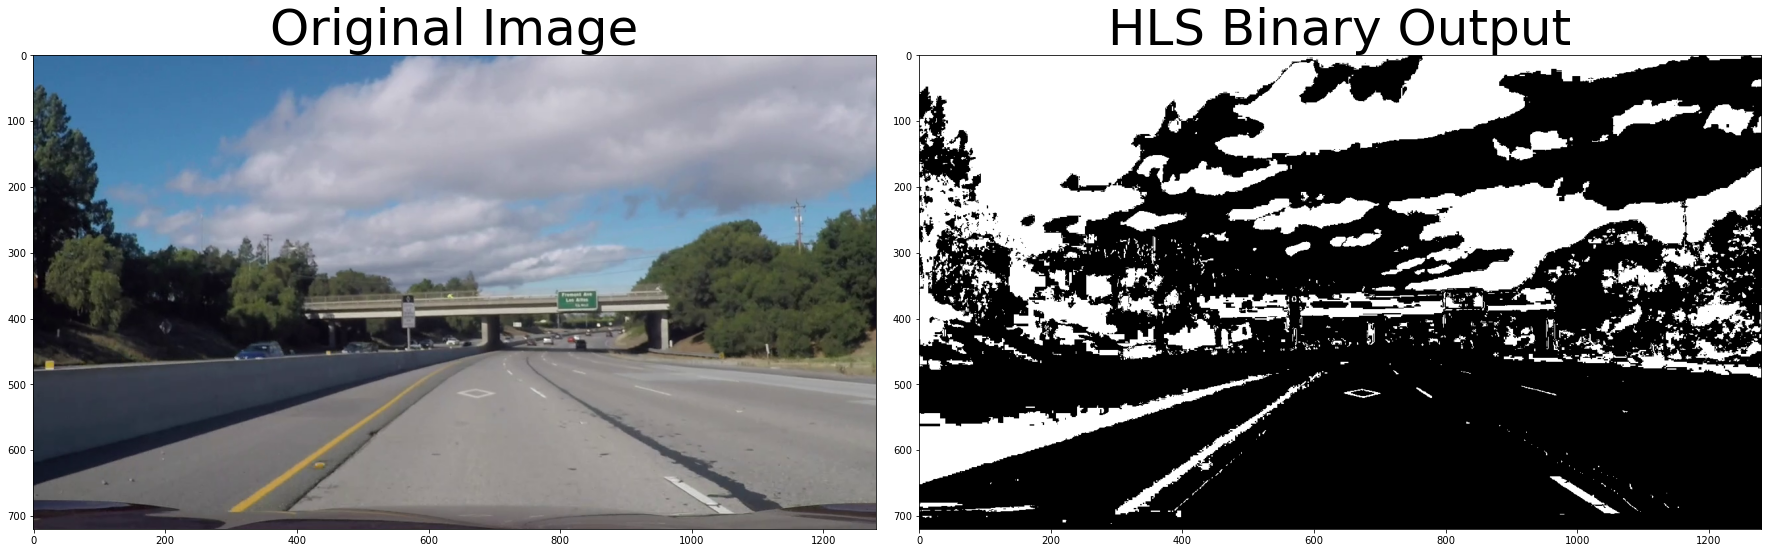

<Figure size 1728x648 with 0 Axes>

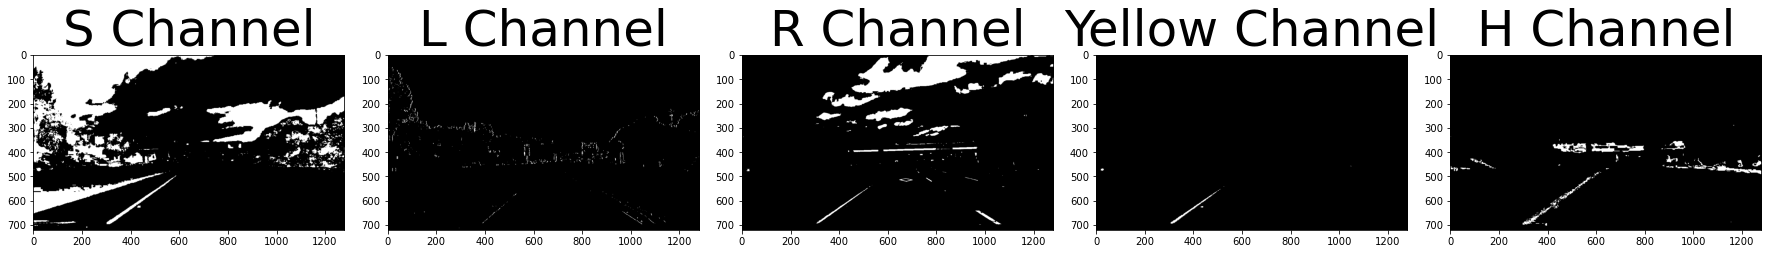

<Figure size 1728x648 with 0 Axes>

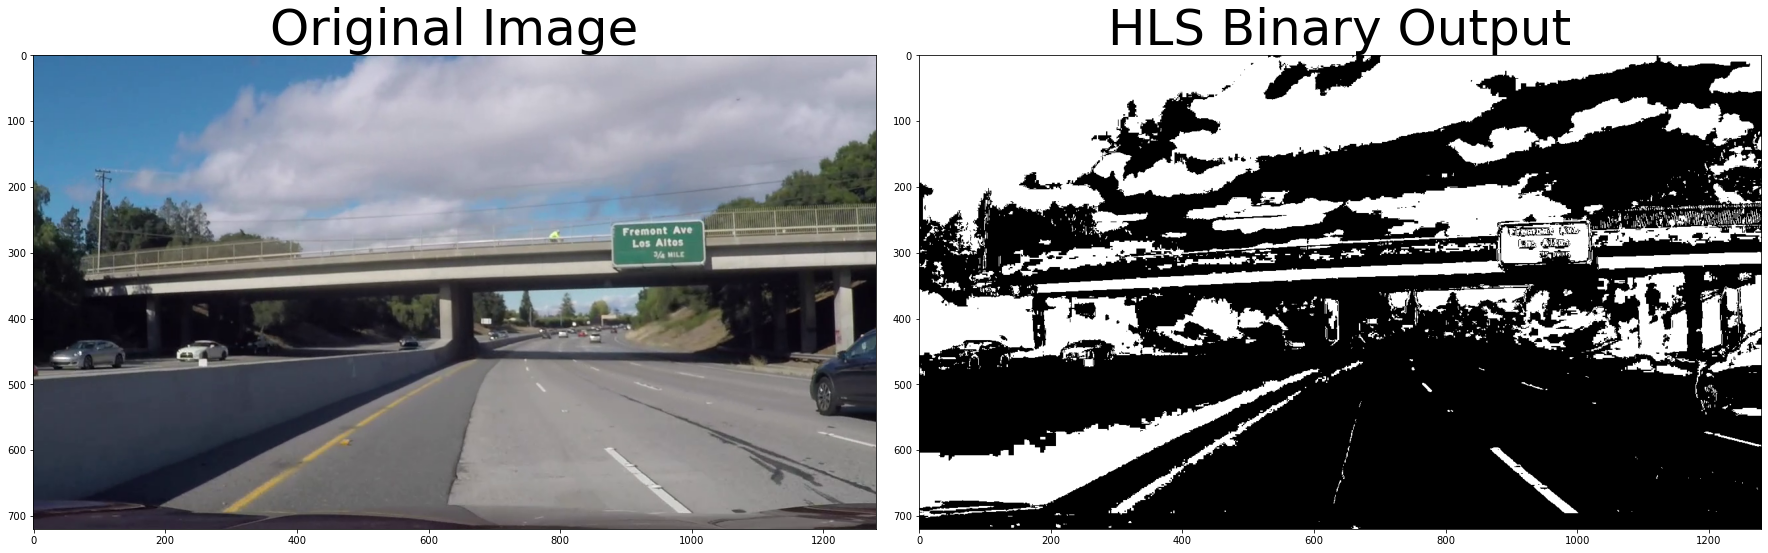

<Figure size 1728x648 with 0 Axes>

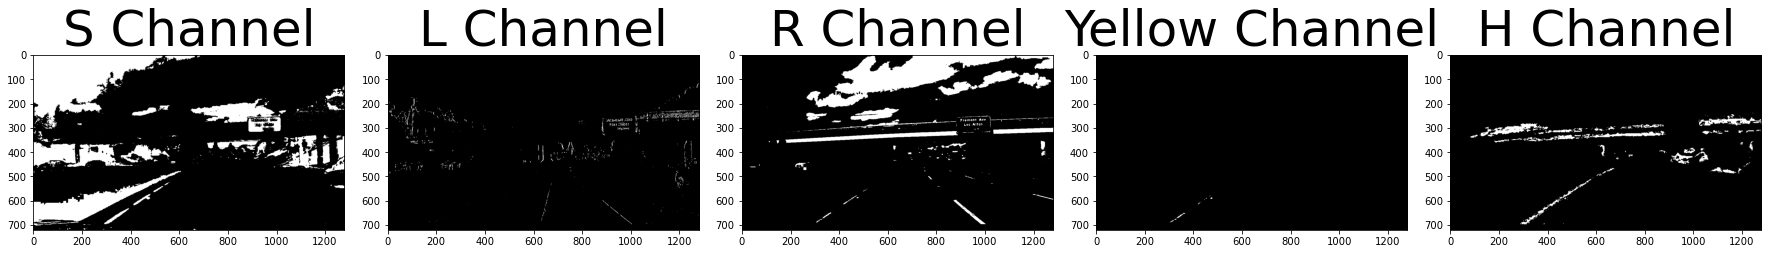

<Figure size 1728x648 with 0 Axes>

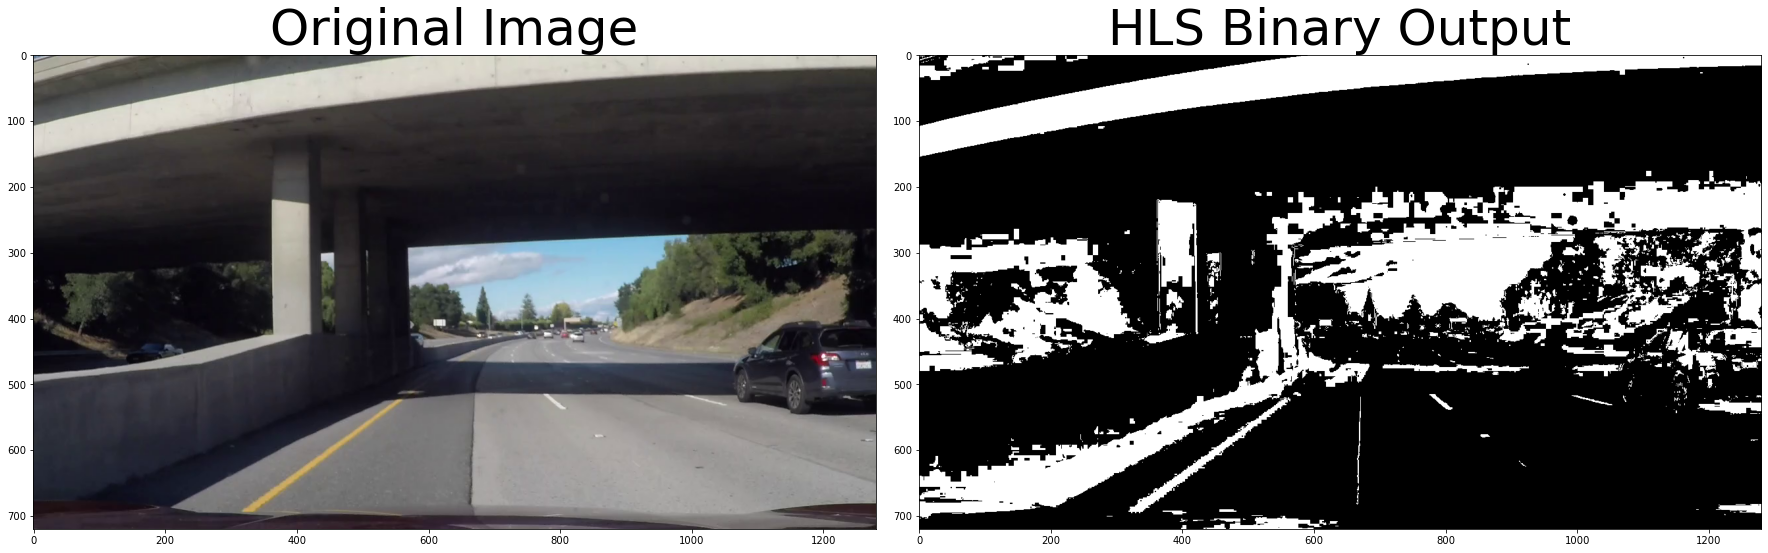

<Figure size 1728x648 with 0 Axes>

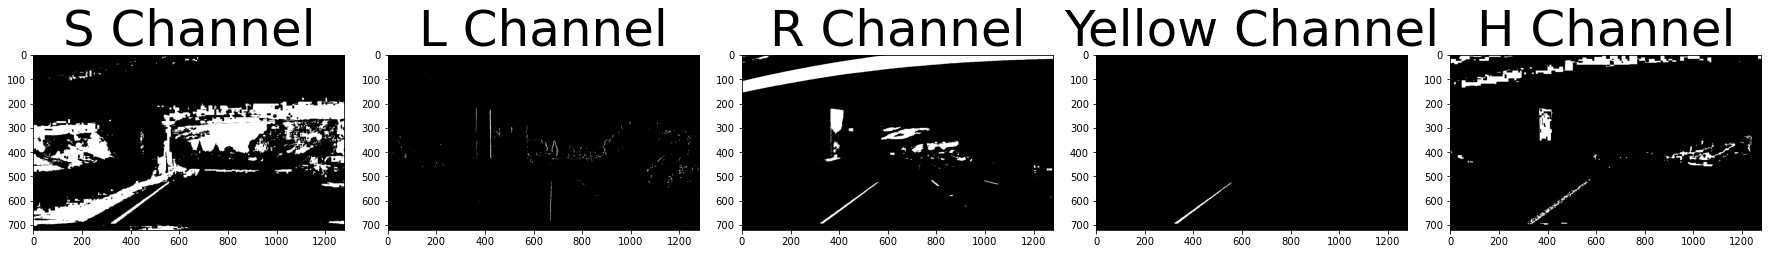

<Figure size 1728x648 with 0 Axes>

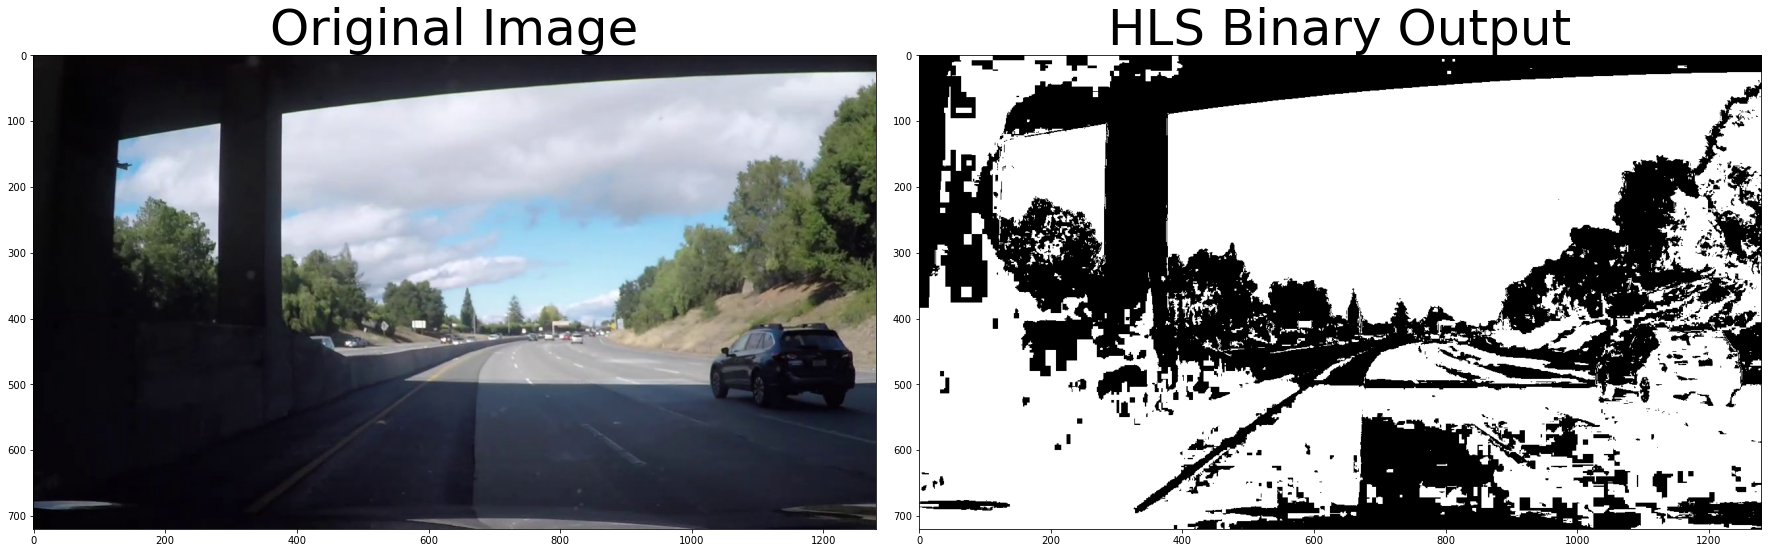

<Figure size 1728x648 with 0 Axes>

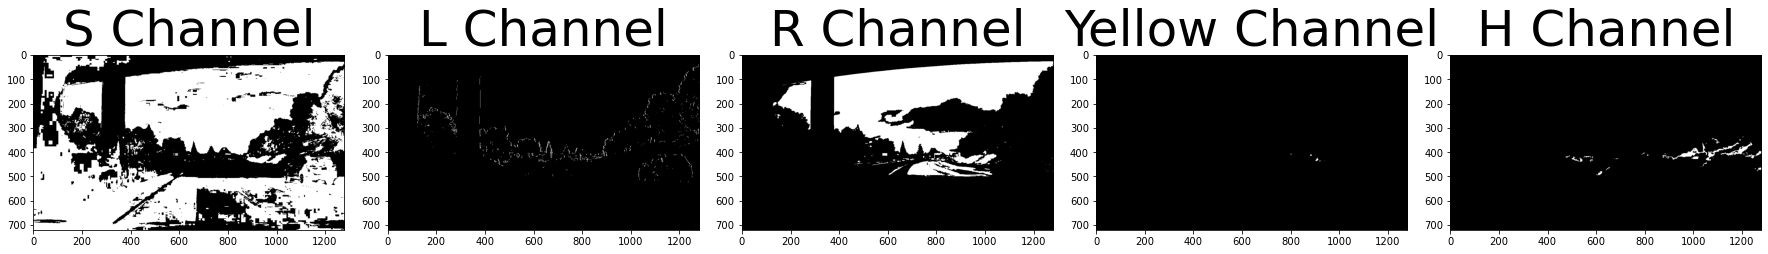

<Figure size 1728x648 with 0 Axes>

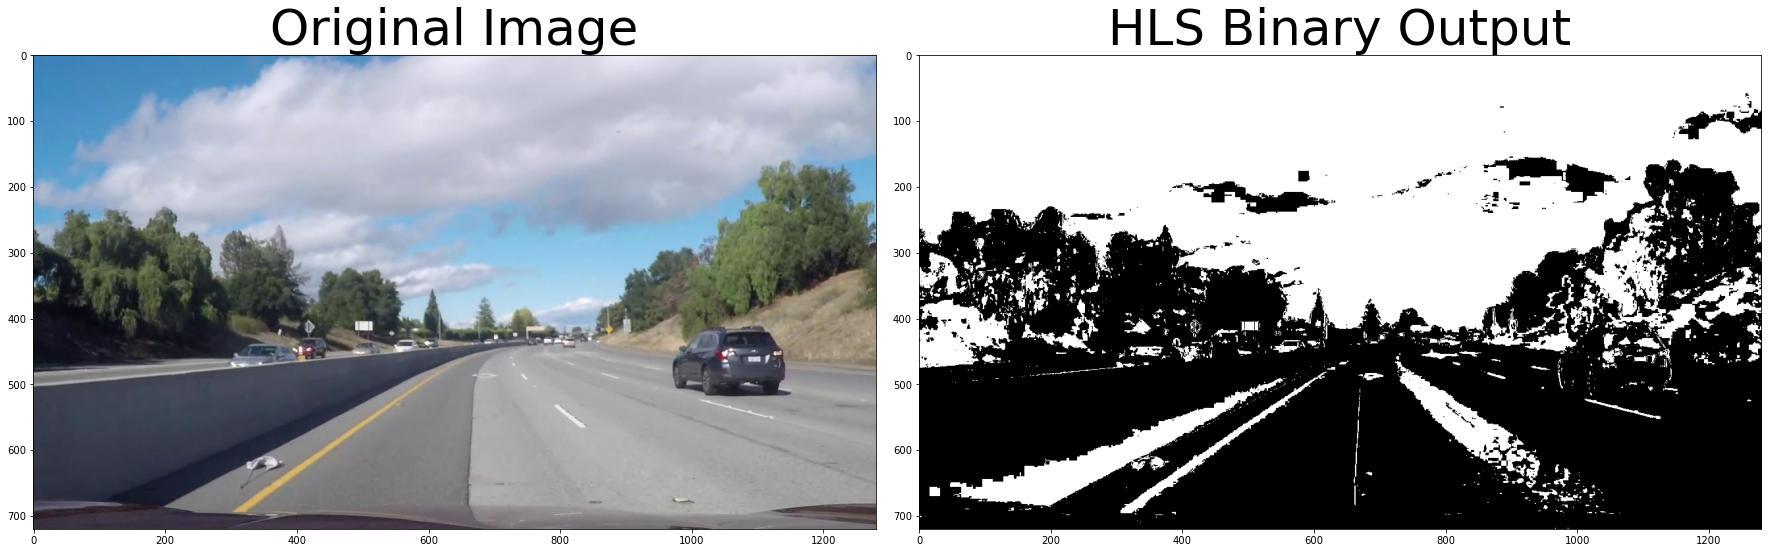

<Figure size 1728x648 with 0 Axes>

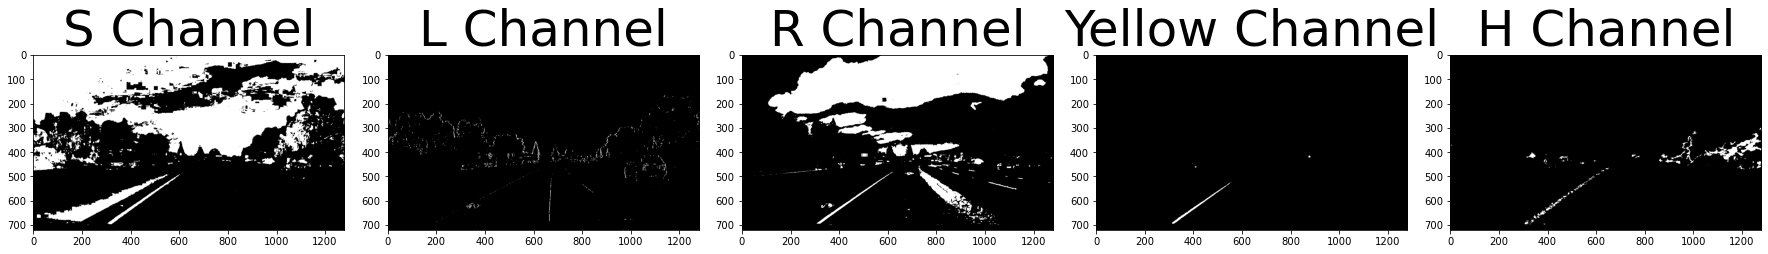

<Figure size 1728x648 with 0 Axes>

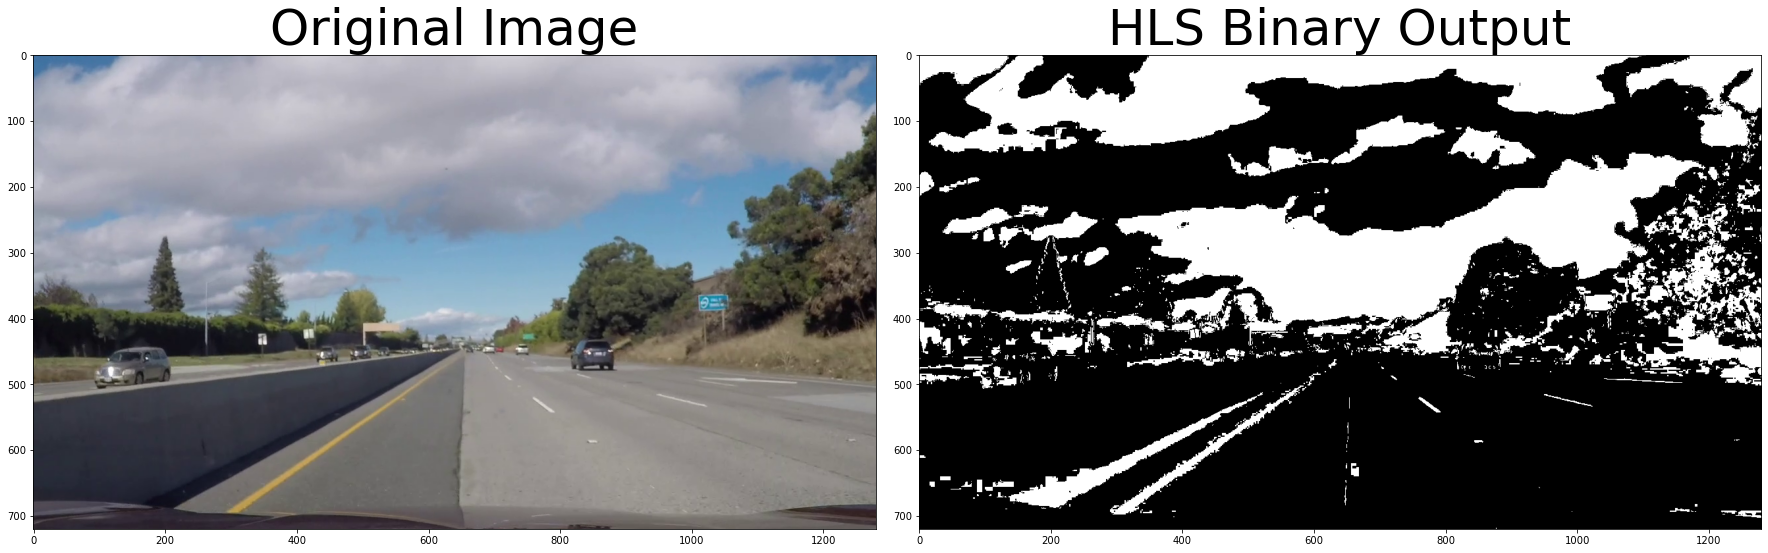

<Figure size 1728x648 with 0 Axes>

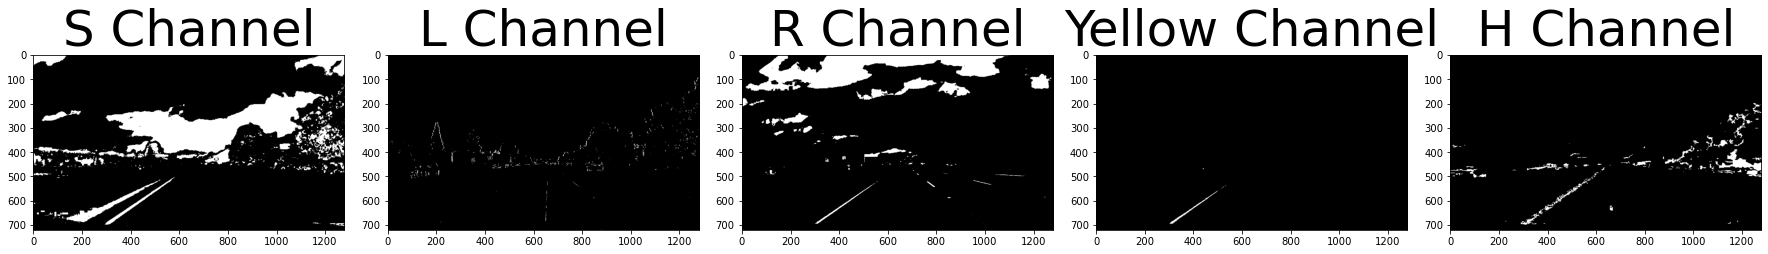

<Figure size 1728x648 with 0 Axes>

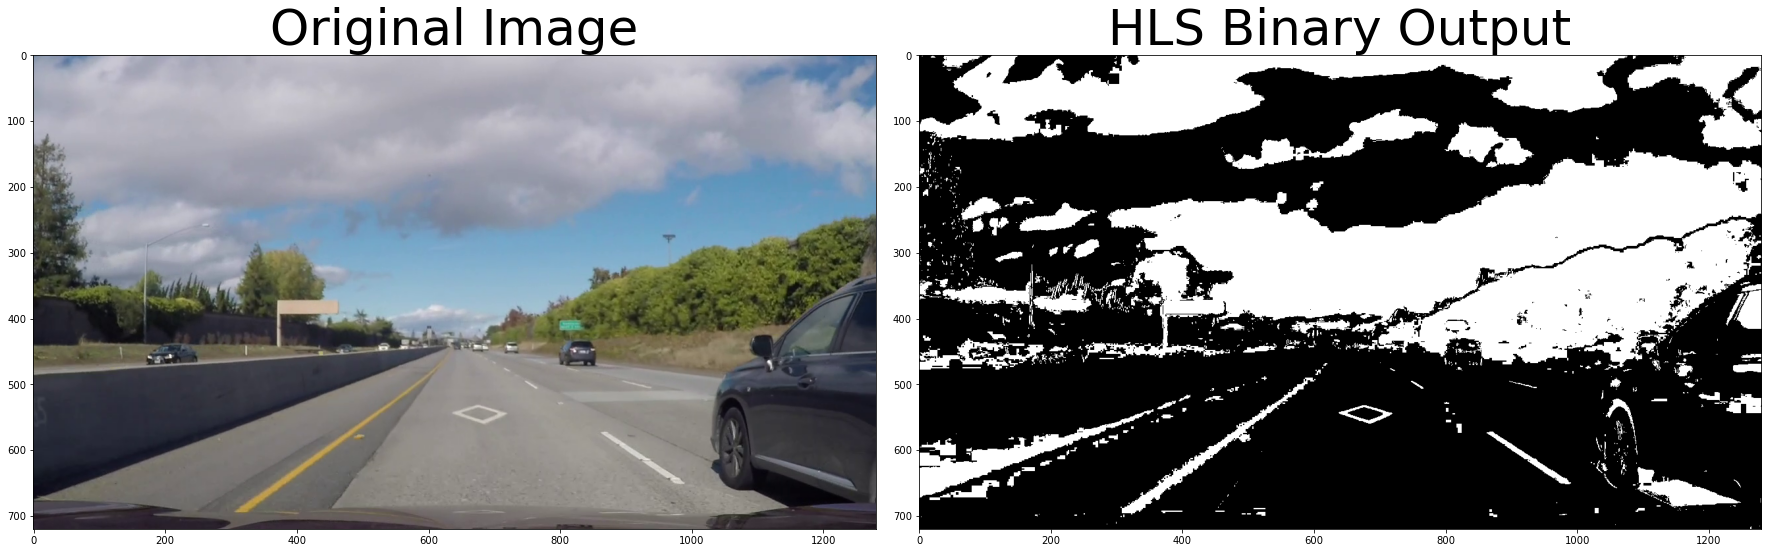

<Figure size 1728x648 with 0 Axes>

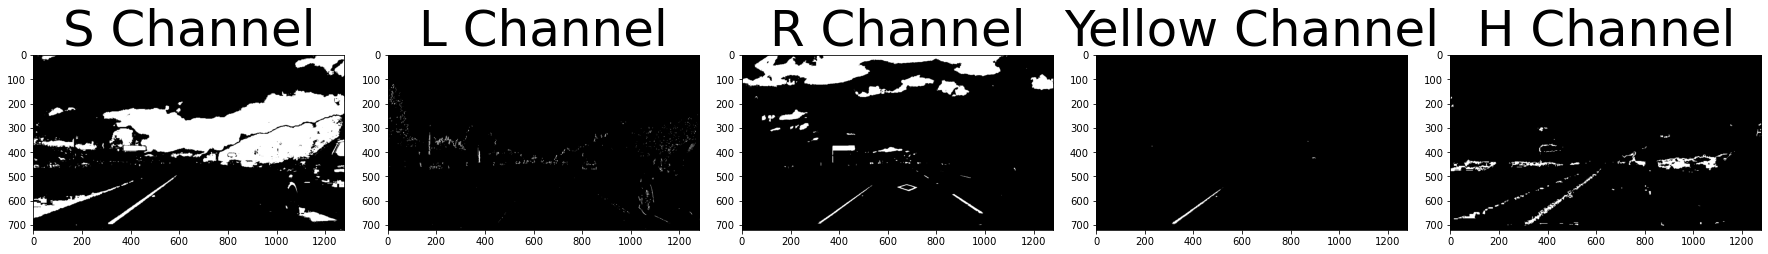

In [98]:
#images = glob.glob('test_images/straight_lines*.jpg')
#images = images + glob.glob('test_images/test*.jpg')
images = glob.glob('test_images_challenge/challenge_test*.png')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)  
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    hls_binary, s_binary_output, l_binary_output, r_binary_output = hls_select(img, s_thresh=(50, 255), l_thresh=(50, 100), r_thresh=(180, 255), h_thresh=(20,25), debug=1)
    
    src = np.float32([[590, 440], [690, 440], [180, 680], [1100, 680]])
    warped, M = undistort_and_unwarp(hls_binary, nx, ny, mtx, dist, offset, src, 0)

In [9]:
def find_lane_pixels(binary_warped, nwindows=9, margin=100, minpix=50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    #nwindows = 9
    # Set the width of the windows +/- margin
    #margin = 100
    # Set minimum number of pixels found to recenter window
    #minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ( (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) ).nonzero()[0]
        good_right_inds = ( (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high) ).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, nwindows=9, margin=100, minpix=50, debug=0):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, nwindows, margin, minpix)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    if debug == 1:
        plt.figure(figsize=(24, 9))
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(binary_warped, cmap='gray')
        ax1.set_title('Binary Wrapped Image', fontsize=50)
        ax2.imshow(out_img, cmap='gray')
        ax2.set_title('Output Image', fontsize=50)
        # Plots the left and right polynomials on the lane lines
        ax2.plot(left_fitx, ploty, color='yellow')
        ax2.plot(right_fitx, ploty, color='yellow')
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    return out_img

In [10]:
images = glob.glob('test_images/test*.jpg')
images = images + glob.glob('test_images/straight_lines*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)  
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    hls_binary, s_binary_output, l_binary_output, r_binary_output = hls_select(img, s_thresh=(100, 255), l_thresh=(25, 100), r_thresh=(200, 255), debug=0)
    
    src = np.float32([[590, 440], [690, 440], [180, 680], [1100, 680]])
    warped, M = undistort_and_unwarp(hls_binary, nx, ny, mtx, dist, offset, src, 0)

    out_img = fit_polynomial(warped, nwindows=8, margin=100, minpix=50, debug=0)

In [11]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, x, y):
        self.lane_pixels_x = x
        self.lane_pixels_y = y
    
    def get_poly_fit(self, poly_order=2):
        self.fit = np.polyfit(self.lane_pixels_y, self.lane_pixels_x, poly_order)
        return self.fit
    
    def get_poly_fit_in_meters(self, ym_per_pix=1, xm_per_pix=1, poly_order=2):
        self.fit_in_meters = np.polyfit(self.lane_pixels_y*ym_per_pix, self.lane_pixels_x*xm_per_pix, poly_order)
        return self.fit_in_meters
    
    def get_lane_fit(self, binary_warped, debug=0):
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        
        try:
            # se al passo precedente ho usato poly_order=2 allora è così altrimenti no, dovrei generalizzare la formula
            self.line_fit_x = self.fit[0]*self.ploty**2 + self.fit[1]*self.ploty + self.fit[2]
        except TypeError:
            # Avoids an error if line_fit is still none or incorrect
            print('The function failed to fit a line!')
            self.line_fit_x = 1*self.ploty**2 + 1*self.ploty

        ## Visualization ##
        if debug == 1:
            show_on_image(binary_warped, binary_warped)
        
        return self.line_fit_x, self.ploty
    
    def get_lane_indexes():
        return None
    
    def get_curvature_in_meter(self, ym_per_pix=1, xm_per_pix=1):
        '''
        Calculates the curvature of polynomial functions in meters.
        '''
        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(self.ploty)
        self.get_poly_fit_in_meters(ym_per_pix, xm_per_pix, 2)

        ##### Compute the R_curve (radius of curvature) #####
        line_curvature = (1+((2*self.fit_in_meters[0]*(ym_per_pix*y_eval)) + self.fit_in_meters[1])**2)**(3/2)/(np.absolute(2*self.fit_in_meters[0])) 

        return line_curvature
    
def show_on_image(binary_warped, out_img, left_fit_x, right_fit_x, left_ploty, right_ploty):
    plt.figure(figsize=(24, 9))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(binary_warped, cmap='gray')
    ax1.set_title('Binary Wrapped Image', fontsize=50)
    ax2.imshow(out_img, cmap='gray')
    ax2.set_title('Output Image', fontsize=50)
    # Plots the left and right polynomials on the lane lines
    ax2.plot(left_fit_x, left_ploty, color='yellow')
    ax2.plot(right_fit_x, right_ploty, color='yellow')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [12]:
def find_lane_pixels_first(binary_warped, nwindows=9, margin=100, minpix=50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    #nwindows = 9
    # Set the width of the windows +/- margin
    #margin = 100
    # Set minimum number of pixels found to recenter window
    #minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ( (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) ).nonzero()[0]
        good_right_inds = ( (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high) ).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial_first(binary_warped, nwindows=9, margin=100, minpix=50, debug=0):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels_first(binary_warped, nwindows, margin, minpix)
    
    # Save Lines
    left_line = Line(leftx, lefty)
    right_line = Line(rightx, righty)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = left_line.get_poly_fit(2) # np.polyfit(lefty, leftx, 2)
    right_fit = right_line.get_poly_fit(2) #np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    left_fitx, left_ploty = left_line.get_lane_fit(binary_warped, 0)
    right_fitx, right_ploty = right_line.get_lane_fit(binary_warped, 0)

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    ## Visualization ##
    if debug == 1:
        show_on_image(binary_warped, out_img, left_fitx, right_fitx, left_ploty, right_ploty)

    return out_img, left_line, right_line

In [13]:
images = glob.glob('test_images/test*.jpg')
images = images + glob.glob('test_images/straight_lines*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)  
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    hls_binary, s_binary_output, l_binary_output, r_binary_output = hls_select(img, s_thresh=(100, 255), l_thresh=(25, 100), r_thresh=(200, 255), debug=0)
    
    src = np.float32([[590, 440], [690, 440], [180, 680], [1100, 680]])
    warped, M = undistort_and_unwarp(hls_binary, nx, ny, mtx, dist, offset, src, 0)

    out_img, left_line, right_line = fit_polynomial_first(warped, nwindows=8, margin=100, minpix=50, debug=0)

In [14]:
def fit_polynomial_prior(binary_warped, left_line_old, right_line_old, margin=100, debug=0):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    #margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_line_old.fit[0]*(nonzeroy**2) + left_line_old.fit[1]*nonzeroy + 
                    left_line_old.fit[2] - margin)) & (nonzerox < (left_line_old.fit[0]*(nonzeroy**2) + 
                    left_line_old.fit[1]*nonzeroy + left_line_old.fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_line_old.fit[0]*(nonzeroy**2) + right_line_old.fit[1]*nonzeroy + 
                    right_line_old.fit[2] - margin)) & (nonzerox < (right_line_old.fit[0]*(nonzeroy**2) + 
                    right_line_old.fit[1]*nonzeroy + right_line_old.fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_line = Line(leftx, lefty)
    right_line = Line(rightx, righty)

    # Fit new polynomials
    left_line.get_poly_fit(2)
    left_fitx, left_ploty = left_line.get_lane_fit(binary_warped, debug=0)
    right_line.get_poly_fit(2)
    right_fitx, right_ploty = right_line.get_lane_fit(binary_warped, debug=0)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((np.zeros(binary_warped.shape, dtype=np.uint8), np.zeros(binary_warped.shape, dtype=np.uint8), np.zeros(binary_warped.shape, dtype=np.uint8)))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, left_ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, left_ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, right_ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, right_ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    if debug == 1:
        # Plot the polynomial lines onto the image
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')
        show_on_image(binary_warped, result, left_fitx, right_fitx, left_ploty, right_ploty)
        ## End visualization steps ##
    
    return result, left_line, right_line

In [28]:
def fit_polynomial_prior_new(binary_warped, left_line_old, right_line_old, margin=100, memory=1, debug=0):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    #margin = 100
    
    # get min size of lines to iterate
    min_size = np.minimum(len(left_line_old), len(right_line_old))
    min_size = np.minimum(min_size, memory)
    left_lane_inds = []
    right_lane_inds = []

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    for x in range(1,min_size+1):
        left_lane_inds.append( (nonzerox > (left_line_old[-x].fit[0]*(nonzeroy**2) + left_line_old[-x].fit[1]*nonzeroy + 
                        left_line_old[-x].fit[2] - margin)) & (nonzerox < (left_line_old[-x].fit[0]*(nonzeroy**2) + 
                        left_line_old[-x].fit[1]*nonzeroy + left_line_old[-x].fit[2] + margin)) )
        right_lane_inds.append( (nonzerox > (right_line_old[-x].fit[0]*(nonzeroy**2) + right_line_old[-x].fit[1]*nonzeroy + 
                        right_line_old[-x].fit[2] - margin)) & (nonzerox < (right_line_old[-x].fit[0]*(nonzeroy**2) + 
                        right_line_old[-x].fit[1]*nonzeroy + right_line_old[-x].fit[2] + margin)) )
    
    # Again, extract left and right line pixel positions
    if min_size == 1:
        leftx = nonzerox[left_lane_inds[-1]]
        lefty = nonzeroy[left_lane_inds[-1]]
        rightx = nonzerox[right_lane_inds[-1]]
        righty = nonzeroy[right_lane_inds[-1]]
    else:
        leftx = nonzerox[ np.logical_and.reduce(left_lane_inds[-min_size:-1]) ]
        lefty = nonzeroy[ np.logical_and.reduce(left_lane_inds[-min_size:-1]) ] 
        rightx = nonzerox[ np.logical_and.reduce(right_lane_inds[-min_size:-1]) ]
        righty = nonzeroy[ np.logical_and.reduce(right_lane_inds[-min_size:-1]) ]
    
    left_line = Line(leftx, lefty)
    right_line = Line(rightx, righty)

    # Fit new polynomials
    left_line.get_poly_fit(2)
    left_fitx, left_ploty = left_line.get_lane_fit(binary_warped, debug=0)
    right_line.get_poly_fit(2)
    right_fitx, right_ploty = right_line.get_lane_fit(binary_warped, debug=0)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds[-1]], nonzerox[left_lane_inds[-1]]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds[-1]], nonzerox[right_lane_inds[-1]]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, left_ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, left_ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, right_ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, right_ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    if debug == 1:
        # Plot the polynomial lines onto the image
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')
        show_on_image(binary_warped, result, left_fitx, right_fitx, left_ploty, right_ploty)
        ## End visualization steps ##
    
    return result, left_line, right_line

In [16]:
images = glob.glob('test_images/straight_lines*.jpg')
#images = images + glob.glob('test_images/test*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)  
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    hls_binary, s_binary_output, l_binary_output, r_binary_output = hls_select(img, s_thresh=(100, 255), l_thresh=(25, 100), r_thresh=(200, 255), debug=0)
    
    src = np.float32([[590, 440], [690, 440], [180, 680], [1100, 680]])
    warped, M = undistort_and_unwarp(hls_binary, nx, ny, mtx, dist, offset, src, 0)

    out_img, left_line_old, right_line_old = fit_polynomial_first(warped, nwindows=8, margin=100, minpix=50, debug=0)
    
    result, left_line, right_line = fit_polynomial_prior(warped, left_line_old, right_line_old, margin=60, debug=0)

In [17]:
def invert_transform(img, binary_warped, M, left_line, right_line, debug=0):
    # Invert the transform matrix from birds_eye (to later make the image back 
    #   to normal below)
    M_inv = np.linalg.inv(M)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.line_fit_x, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective 
    #   matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    if debug == 1:
        plt.figure(figsize=(24, 9))
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(result)
        ax2.set_title('Lane Lines', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    return result

def get_curvature_and_center_delta(left_line, right_line, ym_per_pix=1, xm_per_pix=1, debug=0):
    
    left_line_curvature = left_line.get_curvature_in_meter(ym_per_pix, xm_per_pix)
    right_line_curvature = right_line.get_curvature_in_meter(ym_per_pix, xm_per_pix)
    avg_rad = round(np.mean([left_line_curvature, right_line_curvature]),0)
    
    delta_center_line = 0
    
    if debug == 1:
        print('AVG Line Curvature: ', avg_rad)
    
    return avg_rad, delta_center_line

In [18]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

nx = 9
ny = 6
offset = 300

images = glob.glob('test_images/straight_lines*.jpg')
#images = images + glob.glob('test_images/test*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)  
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    hls_binary, s_binary_output, l_binary_output, r_binary_output = hls_select(img, s_thresh=(100, 255), l_thresh=(25, 100), r_thresh=(200, 255), debug=0)
    
    src = np.float32([[590, 440], [690, 440], [180, 680], [1100, 680]])
    warped, M = undistort_and_unwarp(hls_binary, nx, ny, mtx, dist, offset, src, 0)

    out_img, left_line_old, right_line_old = fit_polynomial_first(warped, nwindows=8, margin=100, minpix=50, debug=0)
    
    get_curvature_and_center_delta(left_line_old, right_line_old, ym_per_pix, xm_per_pix, 0)
    
    result, left_line, right_line = fit_polynomial_prior(warped, left_line_old, right_line_old, margin=60, debug=0)
    
    get_curvature_and_center_delta(left_line, right_line, ym_per_pix, xm_per_pix, 1)
    
    invert_transform(img, warped, M, left_line, right_line, debug=0)

AVG Line Curvature:  3404.0
AVG Line Curvature:  9228.0
AVG Line Curvature:  2239.0
AVG Line Curvature:  13460.0
AVG Line Curvature:  2963.0
AVG Line Curvature:  2401.0
AVG Line Curvature:  593.0
AVG Line Curvature:  832.0
AVG Line Curvature:  1238.0


In [60]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

nx = 9
ny = 6
offset = 200

first_pass = [True]
left_lines_history = []
right_lines_history = []

line_not_found_counter = 0
max_line_not_found_counter = 5

def process_image(image):
    image = np.copy(cv2.resize(image, (1280, 720), interpolation = cv2.INTER_AREA))
    #img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    img = np.copy(image)

    hls_binary, s_binary_output, l_binary_output, r_binary_output = hls_select(img, s_thresh=(100, 255), l_thresh=(10, 100), r_thresh=(200, 255), debug=0)
    
    #src = np.float32([[595,450], [690,450], [175,img.shape[0]], [1110,img.shape[0]]])
    src = np.float32([[590, 440], [690, 440], [180, 680], [1100, 680]])
    warped, M = undistort_and_unwarp(hls_binary, nx, ny, mtx, dist, offset, src, 0)

    if first_pass[-1] == True:
        result, left_line, right_line = fit_polynomial_first(warped, nwindows=8, margin=100, minpix=50, debug=0)
        if left_line is not None and right_line is not None:
            left_lines_history.append(left_line)
            right_lines_history.append(right_line)
            first_pass.append(False)
            print('Lanes Found - Switch to Prior')
    else:
        #result, left_line, right_line = fit_polynomial_prior(warped, left_lines_history[-1], right_lines_history[-1], margin=50, debug=0)
        result, left_line, right_line = fit_polynomial_prior_new(warped, left_lines_history, right_lines_history, margin=50, memory=2, debug=0)
        if left_line is not None and right_line is not None:
            left_lines_history.append(left_line)
            right_lines_history.append(right_line)
            line_not_found_counter = 0
        elif left_line is None or right_line is None:
            line_not_found_counter+=1
            if line_not_found_counter > max_line_not_found_counter:
                line_not_found_counter = 0
                first_pass.append(True)
                print('Lane not Found - Switch back to Moving Windows')
    
    avg_rad, delta_center_line = get_curvature_and_center_delta(left_lines_history[-1], right_lines_history[-1], ym_per_pix, xm_per_pix, 0)
    
    output = invert_transform(img, warped, M, left_lines_history[-1], right_lines_history[-1], debug=0)
    
    # List car's position in relation to middle on the image and radius of curvature
    radius_text = 'Radius of Curvature = {}(m)'.format(avg_rad)
    center_text = '{} meters left of center'.format(round(delta_center_line,2))
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(output, center_text, (10,50), font, 1,(255,255,255),2)
    cv2.putText(output, radius_text, (10,100), font, 1,(255,255,255),2)
    
    s_binary_output = np.dstack((s_binary_output, s_binary_output, s_binary_output))*255
    l_binary_output = np.dstack((l_binary_output, l_binary_output, l_binary_output))*255
    r_binary_output = np.dstack((r_binary_output, r_binary_output, r_binary_output))*255
    warped = np.dstack((warped, warped, warped))*255
    warped = cv2.resize(warped, (400, 225), interpolation=cv2.INTER_AREA)
    s_binary_output = cv2.resize(s_binary_output, (400, 225), interpolation=cv2.INTER_AREA)
    l_binary_output = cv2.resize(l_binary_output, (400, 225), interpolation=cv2.INTER_AREA)
    r_binary_output = cv2.resize(r_binary_output, (400, 225), interpolation=cv2.INTER_AREA)
    result = cv2.resize(result, (400, 225), interpolation=cv2.INTER_AREA)
    
    '''
    # Select the region in the background where we want to add the image and add the images using cv2.addWeighted()
    s_binary_output_image = cv2.addWeighted(output[0:225, 880:1280, :], 0, s_binary_output, 1, 0)
    l_binary_output_image = cv2.addWeighted(output[225:450, 880:1280, :], 0, l_binary_output, 1, 0)
    #r_binary_output_image = cv2.addWeighted(output[450:675, 880:1280, :], 0, r_binary_output, 1, 0)
    warped_image = cv2.addWeighted(output[450:675, 880:1280, :], 0, warped, 1, 0)
    # Change the region with the result
    output[0:225, 880:1280, :] = s_binary_output_image
    output[225:450, 880:1280, :] = l_binary_output_image
    #output[450:675, 880:1280, :] = r_binary_output_image
    output[450:675, 880:1280, :] = warped_image
    '''
    
    #output = cv2.cvtColor(output,cv2.COLOR_RGB2BGR)
    #output = warped
    
    return output

In [54]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

nx = 9
ny = 6
offset = 200

first_pass = [True]
left_lines_history = []
right_lines_history = []

line_not_found_counter = 0
max_line_not_found_counter = 5

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Lanes Found - Switch to Prior
Moviepy - Building video test_videos_output/project_video.mp4.
Moviepy - Writing video test_videos_output/project_video.mp4




t:   5%|███▌                                                               | 67/1260 [00:23<07:08,  2.78it/s, now=None]


t:  11%|██████▉                                                           | 133/1260 [00:46<06:35,  2.85it/s, now=None]


t:  16%|██████████▍                                                       | 199/1260 [01:10<06:22,  2.77it/s, now=None]


t:  21%|█████████████▉                                                    | 265/1260 [01:34<06:05,  2.72it/s, now=None]


t:  26%|█████████████████▎                                                | 331/1260 [01:58<05:36,  2.76it/s, now=None]


t:  32%|████████████████████▊                                             | 397/1260 [02:22<05:12,  2.76it/s, now=None]


t:  37%|████████████████████████▎                                         | 463/1260 [02:47<04:58,  2.67it/s, now=None]


t:  42%|███████████████████████████▋                                      | 529/1260 [03:09<03:42,  3.29it/s, now=None]


t:  47%|███████████████████████████████▏                                  | 595/1260 [03:31<02:47,  3.98it/s, now=None]


t:  52%|██████████████████████████████████▌                               | 661/1260 [03:55<03:40,  2.72it/s, now=None]


t:  58%|██████████████████████████████████████                            | 727/1260 [04:19<03:10,  2.80it/s, now=None]


t:  63%|█████████████████████████████████████████▌                        | 793/1260 [04:45<03:01,  2.57it/s, now=None]


t:  68%|████████████████████████████████████████████▉                     | 859/1260 [05:11<02:42,  2.46it/s, now=None]


t:  73%|████████████████████████████████████████████████▍                 | 925/1260 [05:38<01:57,  2.84it/s, now=None]


t:  79%|███████████████████████████████████████████████████▉              | 991/1260 [06:05<02:21,  1.90it/s, now=None]


t:  84%|██████████████████████████████████████████████████████▌          | 1057/1260 [06:36<01:18,  2.59it/s, now=None]


t:  89%|█████████████████████████████████████████████████████████▉       | 1123/1260 [07:01<00:52,  2.61it/s, now=None]


t:  94%|█████████████████████████████████████████████████████████████▎   | 1189/1260 [07:26<00:25,  2.78it/s, now=None]


t: 100%|████████████████████████████████████████████████████████████████▋| 1255/1260 [07:51<00:01,  2.77it/s, now=None]


t:   1%|▍                                                                   | 9/1260 [58:23<10:32,  1.98it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/project_video.mp4
Wall time: 7min 55s


In [56]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [105]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

nx = 9
ny = 6
offset = 200

first_pass = [True]
left_lines_history = []
right_lines_history = []

line_not_found_counter = 0
max_line_not_found_counter = 5

def process_image(image):
    image = np.copy(cv2.resize(image, (1280, 720), interpolation = cv2.INTER_AREA))
    #img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    img = np.copy(image)

    hls_binary, s_binary_output, l_binary_output, r_binary_output = hls_select(img, s_thresh=(50, 255), l_thresh=(50, 100), r_thresh=(180, 255), h_thresh=(20,25), debug=0)
    
    #src = np.float32([[595,450], [690,450], [175,img.shape[0]], [1110,img.shape[0]]])
    src = np.float32([[590, 460], [690, 460], [180, 680], [1100, 680]])
    warped, M = undistort_and_unwarp(hls_binary, nx, ny, mtx, dist, offset, src, 0)

    if first_pass[-1] == True:
        result, left_line, right_line = fit_polynomial_first(warped, nwindows=8, margin=100, minpix=50, debug=0)
        if left_line is not None and right_line is not None:
            left_lines_history.append(left_line)
            right_lines_history.append(right_line)
            first_pass.append(False)
            print('Lanes Found - Switch to Prior')
    else:
        #result, left_line, right_line = fit_polynomial_prior(warped, left_lines_history[-1], right_lines_history[-1], margin=50, debug=0)
        result, left_line, right_line = fit_polynomial_prior_new(warped, left_lines_history, right_lines_history, margin=25, memory=2, debug=0)
        if left_line is not None and right_line is not None:
            left_lines_history.append(left_line)
            right_lines_history.append(right_line)
            line_not_found_counter = 0
        elif left_line is None or right_line is None:
            line_not_found_counter+=1
            if line_not_found_counter > max_line_not_found_counter:
                line_not_found_counter = 0
                first_pass.append(True)
                print('Lane not Found - Switch back to Moving Windows')
    
    avg_rad, delta_center_line = get_curvature_and_center_delta(left_lines_history[-1], right_lines_history[-1], ym_per_pix, xm_per_pix, 0)
    
    output = invert_transform(img, warped, M, left_lines_history[-1], right_lines_history[-1], debug=0)
    
    # List car's position in relation to middle on the image and radius of curvature
    radius_text = 'Radius of Curvature = {}(m)'.format(avg_rad)
    center_text = '{} meters left of center'.format(round(delta_center_line,2))
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(output, center_text, (10,50), font, 1,(255,255,255),2)
    cv2.putText(output, radius_text, (10,100), font, 1,(255,255,255),2)
    
    s_binary_output = np.dstack((s_binary_output, s_binary_output, s_binary_output))*255
    l_binary_output = np.dstack((l_binary_output, l_binary_output, l_binary_output))*255
    r_binary_output = np.dstack((r_binary_output, r_binary_output, r_binary_output))*255
    warped = np.dstack((warped, warped, warped))*255
    warped = cv2.resize(warped, (400, 225), interpolation=cv2.INTER_AREA)
    s_binary_output = cv2.resize(s_binary_output, (400, 225), interpolation=cv2.INTER_AREA)
    l_binary_output = cv2.resize(l_binary_output, (400, 225), interpolation=cv2.INTER_AREA)
    r_binary_output = cv2.resize(r_binary_output, (400, 225), interpolation=cv2.INTER_AREA)
    result = cv2.resize(result, (400, 225), interpolation=cv2.INTER_AREA)
    
    # Select the region in the background where we want to add the image and add the images using cv2.addWeighted()
    s_binary_output_image = cv2.addWeighted(output[0:225, 880:1280, :], 0, s_binary_output, 1, 0)
    l_binary_output_image = cv2.addWeighted(output[225:450, 880:1280, :], 0, l_binary_output, 1, 0)
    #r_binary_output_image = cv2.addWeighted(output[450:675, 880:1280, :], 0, r_binary_output, 1, 0)
    warped_image = cv2.addWeighted(output[450:675, 880:1280, :], 0, warped, 1, 0)
    # Change the region with the result
    output[0:225, 880:1280, :] = s_binary_output_image
    output[225:450, 880:1280, :] = l_binary_output_image
    #output[450:675, 880:1280, :] = r_binary_output_image
    output[450:675, 880:1280, :] = warped_image
    
    #output = cv2.cvtColor(output,cv2.COLOR_RGB2BGR)
    #output = warped
    
    return output

In [106]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

nx = 9
ny = 6
offset = 100

first_pass = [True]
left_lines_history = []
right_lines_history = []

line_not_found_counter = 0
max_line_not_found_counter = 5

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

challenge_video = 'test_videos_output/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("test_videos/challenge_video.mp4")
challenge_video_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_video_clip.write_videofile(challenge_video, audio=False)


                                                                                                                    
t:   1%|▊                                                                | 16/1199 [5:03:31<05:34,  3.53it/s, now=None]
                                                                                                                    
t:   0%|                                                                             | 0/485 [00:00<?, ?it/s, now=None]

Lanes Found - Switch to Prior
Moviepy - Building video test_videos_output/challenge_video.mp4.
Moviepy - Writing video test_videos_output/challenge_video.mp4



                                                                                                                       
                                                                                                                    
t:   1%|▊                                                                | 16/1199 [5:05:37<05:34,  3.53it/s, now=None]
                                                                                                                    
t:   1%|▊                                                                | 16/1199 [5:05:37<05:34,  3.53it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/challenge_video.mp4
Wall time: 2min 6s


In [107]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video))

In [108]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

nx = 9
ny = 6
offset = 200

first_pass = [True]
left_lines_history = []
right_lines_history = []

line_not_found_counter = 0
max_line_not_found_counter = 5

def process_image(image):
    image = np.copy(cv2.resize(image, (1280, 720), interpolation = cv2.INTER_AREA))
    #img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    img = np.copy(image)

    hls_binary, s_binary_output, l_binary_output, r_binary_output = hls_select(img, s_thresh=(50, 255), l_thresh=(50, 100), r_thresh=(180, 255), h_thresh=(20,25), debug=0)
    
    #src = np.float32([[595,450], [690,450], [175,img.shape[0]], [1110,img.shape[0]]])
    src = np.float32([[500, 500], [780, 500], [180, 680], [1100, 680]])
    warped, M = undistort_and_unwarp(hls_binary, nx, ny, mtx, dist, offset, src, 0)

    if first_pass[-1] == True:
        result, left_line, right_line = fit_polynomial_first(warped, nwindows=8, margin=100, minpix=50, debug=0)
        if left_line is not None and right_line is not None:
            left_lines_history.append(left_line)
            right_lines_history.append(right_line)
            first_pass.append(False)
            print('Lanes Found - Switch to Prior')
    else:
        #result, left_line, right_line = fit_polynomial_prior(warped, left_lines_history[-1], right_lines_history[-1], margin=50, debug=0)
        result, left_line, right_line = fit_polynomial_prior_new(warped, left_lines_history, right_lines_history, margin=25, memory=2, debug=0)
        if left_line is not None and right_line is not None:
            left_lines_history.append(left_line)
            right_lines_history.append(right_line)
            line_not_found_counter = 0
        elif left_line is None or right_line is None:
            line_not_found_counter+=1
            if line_not_found_counter > max_line_not_found_counter:
                line_not_found_counter = 0
                first_pass.append(True)
                print('Lane not Found - Switch back to Moving Windows')
    
    avg_rad, delta_center_line = get_curvature_and_center_delta(left_lines_history[-1], right_lines_history[-1], ym_per_pix, xm_per_pix, 0)
    
    output = invert_transform(img, warped, M, left_lines_history[-1], right_lines_history[-1], debug=0)
    
    # List car's position in relation to middle on the image and radius of curvature
    radius_text = 'Radius of Curvature = {}(m)'.format(avg_rad)
    center_text = '{} meters left of center'.format(round(delta_center_line,2))
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(output, center_text, (10,50), font, 1,(255,255,255),2)
    cv2.putText(output, radius_text, (10,100), font, 1,(255,255,255),2)
    
    s_binary_output = np.dstack((s_binary_output, s_binary_output, s_binary_output))*255
    l_binary_output = np.dstack((l_binary_output, l_binary_output, l_binary_output))*255
    r_binary_output = np.dstack((r_binary_output, r_binary_output, r_binary_output))*255
    warped = np.dstack((warped, warped, warped))*255
    warped = cv2.resize(warped, (400, 225), interpolation=cv2.INTER_AREA)
    s_binary_output = cv2.resize(s_binary_output, (400, 225), interpolation=cv2.INTER_AREA)
    l_binary_output = cv2.resize(l_binary_output, (400, 225), interpolation=cv2.INTER_AREA)
    r_binary_output = cv2.resize(r_binary_output, (400, 225), interpolation=cv2.INTER_AREA)
    result = cv2.resize(result, (400, 225), interpolation=cv2.INTER_AREA)
    
    # Select the region in the background where we want to add the image and add the images using cv2.addWeighted()
    s_binary_output_image = cv2.addWeighted(output[0:225, 880:1280, :], 0, s_binary_output, 1, 0)
    l_binary_output_image = cv2.addWeighted(output[225:450, 880:1280, :], 0, l_binary_output, 1, 0)
    #r_binary_output_image = cv2.addWeighted(output[450:675, 880:1280, :], 0, r_binary_output, 1, 0)
    warped_image = cv2.addWeighted(output[450:675, 880:1280, :], 0, warped, 1, 0)
    # Change the region with the result
    output[0:225, 880:1280, :] = s_binary_output_image
    output[225:450, 880:1280, :] = l_binary_output_image
    #output[450:675, 880:1280, :] = r_binary_output_image
    output[450:675, 880:1280, :] = warped_image
    
    #output = cv2.cvtColor(output,cv2.COLOR_RGB2BGR)
    #output = warped
    
    return output

In [109]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

nx = 9
ny = 6
offset = 200

first_pass = [True]
left_lines_history = []
right_lines_history = []

line_not_found_counter = 0
max_line_not_found_counter = 5

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

harder_challenge_video = 'test_videos_output/harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("test_videos/harder_challenge_video.mp4")
challenge_video_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_video_clip.write_videofile(harder_challenge_video, audio=False)


                                                                                                                    
t:   1%|▊                                                                | 16/1199 [5:07:09<05:34,  3.53it/s, now=None]
                                                                                                                    
t:   0%|                                                                            | 0/1199 [00:00<?, ?it/s, now=None]

Lanes Found - Switch to Prior
Moviepy - Building video test_videos_output/harder_challenge_video.mp4.
Moviepy - Writing video test_videos_output/harder_challenge_video.mp4



                                                                                                                       
                                                                                                                    
t:   1%|▊                                                                | 16/1199 [5:15:38<05:34,  3.53it/s, now=None]
                                                                                                                    
t:   1%|▊                                                                | 16/1199 [5:15:38<05:34,  3.53it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/harder_challenge_video.mp4
Wall time: 8min 28s


In [111]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_video))